# TUGAS 4 – VALIDASI DAN SAMPLING

- **Nama:** Angelica Widyastuti Kolo  
- **NIM:** A11.2021.13212  
- **Mata Kuliah:** Bengkel Koding Data Science  
- **Topik:** Handling Imbalance & Cross Validation  

## Bagian 1 — Import Library dan Load Dataset

**Penjelasan singkat:** Import library yang diperlukan, lalu coba baca dataset `adult.data` dari beberapa sumber: (1) file lokal `./adult.data`, (2) file di Google Drive (jika di-mount), atau (3) langsung dari UCI repository.

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing & ML
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
except Exception as e:
    print('imblearn tidak ditemukan. Install dengan: pip install imblearn')
    raise

# Try to load dataset from common locations, fallback to UCI url
paths_to_try = ['./adult.data', '/content/adult.data', '/mnt/data/census_income_dataset/adult.data']
df = None
for p in paths_to_try:
    try:
        df = pd.read_csv(p, header=None, na_values=' ?', skipinitialspace=True)
        print(f'Dataset loaded from: {p}')
        break
    except Exception:
        pass

if df is None:
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    df = pd.read_csv(url, header=None, na_values=' ?', skipinitialspace=True)
    print('Dataset downloaded from UCI repository.')

Dataset loaded from: ./adult.data


In [3]:
# Assign column names
df.columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

print('Shape dataset:', df.shape)
df.head()

Shape dataset: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Dokumentasi Hasil

Setelah menjalankan perintah pembacaan dataset menggunakan pd.read_csv(), terlihat bahwa dataset berhasil dimuat dengan jumlah baris 32.561 dan kolom sebanyak 15. Artinya, terdapat 32.561 data individu dengan 15 atribut yang merepresentasikan informasi demografis serta status pendapatan mereka.

Tabel lima baris pertama dari dataset memperlihatkan struktur kolom yang terdiri dari data numerik dan kategorikal, seperti:
- age → usia individu
- workclass → jenis pekerjaan atau status kerja
- fnlwgt → bobot sampel (final weight)
- education dan education-num → tingkat pendidikan dalam bentuk teks dan angka
- marital-status, occupation, relationship, race, sex → atribut demografis
- capital-gain, capital-loss, hours-per-week → atribut numerik terkait ekonomi
- native-country → negara asal
- income → kolom target, berisi dua kategori: <=50K dan >50K

Berdasarkan hasil di atas, dapat disimpulkan bahwa dataset berhasil dimuat tanpa error dan siap untuk tahap eksplorasi dan pembersihan data berikutnya.

## Bagian 2 — Eksplorasi & Pembersihan Data

**Penjelasan singkat:** Cek info, missing values, duplikasi, dan tampilkan distribusi target awal untuk melihat apakah dataset imbalanced.

In [4]:
# Info dasar
print(df.info())
print('\nJumlah missing values per kolom:')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None

Jumlah missing values per kolom:
age               0
workclass         0
fnlwgt        

In [5]:
# Drop duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f'Baris sebelum drop duplicates: {before}, setelah: {after}')

Baris sebelum drop duplicates: 32561, setelah: 32537


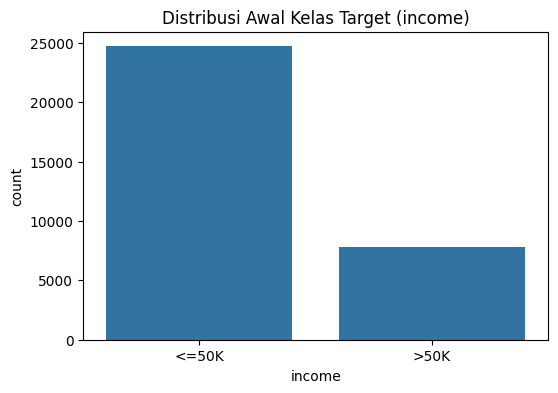

In [6]:
# Tampilkan distribusi target
plt.figure(figsize=(6,4))
sns.countplot(x='income', data=df)
plt.title('Distribusi Awal Kelas Target (income)')
plt.show()

In [7]:
# Tampilkan proporsi kelas
print('\nProporsi kelas:')
print(df['income'].value_counts(normalize=True))


Proporsi kelas:
income
<=50K    0.759074
>50K     0.240926
Name: proportion, dtype: float64


### Dokumentasi Hasil
- Distribusi kelas target (income) menunjukkan ketidakseimbangan yang jelas: <=50K: ~24.000 individu, >50K: ~7.800 individu
- Mayoritas (~75%) memiliki pendapatan ≤50K, sementara hanya ~25% yang >50K.

### Menangani Missing Values & Tipe Data

**Penjelasan:** Untuk kolom kategorikal dengan missing values (`NaN`), kita akan mengganti dengan nilai `'Unknown'` agar tidak menghapus baris terlalu banyak. Pilihan lain adalah menghapus baris, namun untuk menjaga informasi, kita isi dengan kategori khusus.

In [8]:
# Mengisi missing values pada kolom kategorikal dengan 'Unknown'
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('income')  # exclude target
df[cat_cols] = df[cat_cols].fillna('Unknown')

print('Missing values setelah imputasi:')
print(df.isnull().sum())

Missing values setelah imputasi:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


### Dokumentasi Hasil
Imputasi missing values pada kolom kategorikal telah berhasil dilakukan dengan mengganti nilai kosong menjadi 'Unknown'.

Hasil pemeriksaan setelah imputasi:

- Tidak ada missing values di seluruh kolom (0 di semua kolom).
- Kolom target income tidak diimputasi karena dikecualikan dari proses.

Dataset kini sepenuhnya bersih dari missing values dan siap untuk tahap analisis selanjutnya.

## Bagian 3 — Encoding (Ordinal & One-Hot) dan Scaling

**Penjelasan:** Buat dua versi dataset: `df_oe` (Ordinal Encoding) dan `df_ohe` (One-Hot Encoding). Setelah encoding, lakukan scaling pada fitur numerik (StandardScaler).

In [9]:
# Pisahkan X dan y
X = df.drop('income', axis=1)
y = df['income'].copy()

In [10]:
# ORDINAL ENCODER
X_oe = X.copy()
ord_cols = X_oe.select_dtypes(include='object').columns.tolist()
ordinal_encoder = OrdinalEncoder()
X_oe[ord_cols] = ordinal_encoder.fit_transform(X_oe[ord_cols])

# ONE-HOT ENCODER
X_ohe_cat = X.select_dtypes(include='object')
ohe = OneHotEncoder(drop='first', sparse_output=False)
X_ohe_cat_trans = pd.DataFrame(ohe.fit_transform(X_ohe_cat), columns=ohe.get_feature_names_out(X_ohe_cat.columns))
X_ohe = pd.concat([X_ohe_cat_trans.reset_index(drop=True), X.select_dtypes(exclude='object').reset_index(drop=True)], axis=1)

In [11]:
# Scaling numeric features for both datasets
num_cols_oe = X_oe.select_dtypes(include=['int64','float64']).columns.tolist()
scaler = StandardScaler()
X_oe[num_cols_oe] = scaler.fit_transform(X_oe[num_cols_oe])

num_cols_ohe = X_ohe.select_dtypes(include=['int64','float64']).columns.tolist()
X_ohe[num_cols_ohe] = scaler.fit_transform(X_ohe[num_cols_ohe])

In [12]:
# Create final DataFrames with target
df_oe = pd.concat([X_oe, y.reset_index(drop=True)], axis=1)
df_ohe = pd.concat([X_ohe, y.reset_index(drop=True)], axis=1)

print('Shapes: df_oe =', df_oe.shape, ', df_ohe =', df_ohe.shape)
df_oe.head()

Shapes: df_oe = (32561, 15) , df_ohe = (32537, 101)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.030390,2.149971,-1.063569,-0.335266,1.134777,0.921857,-1.317629,-0.277864,0.393685,0.703020,0.148292,-0.216743,-0.035664,0.291335,<=50K
1,0.836973,1.463357,-1.008668,-0.335266,1.134777,-0.405919,-0.608318,-0.900126,0.393685,0.703020,-0.145975,-0.216743,-2.222483,0.291335,<=50K
2,-0.042936,0.090129,0.245040,0.181519,-0.420679,-1.733696,-0.135444,-0.277864,0.393685,0.703020,-0.145975,-0.216743,-0.035664,0.291335,<=50K
3,1.056950,0.090129,0.425752,-2.402406,-1.198407,-0.405919,-0.135444,-0.900126,-1.962488,0.703020,-0.145975,-0.216743,-0.035664,0.291335,<=50K
4,-0.776193,0.090129,1.408066,-0.335266,1.134777,-0.405919,0.810304,2.211186,-1.962488,-1.422436,-0.145975,-0.216743,-0.035664,-4.056151,<=50K


### Dokumentasi Hasil
Output One-Hot Encoding (OHE) dan Shape Dataset:
- Shape sebelum OHE: df_oe = (32.561 baris, 15 kolom)
- Shape setelah OHE: df_ohe = (32.537 baris, 101 kolom)

Penjelasan tabel:
- Tabel menampilkan 5 baris pertama hasil one-hot encoding dari fitur kategorikal.
- Setiap nilai unik pada kolom kategorikal (seperti workclass, education, dll.) telah diubah menjadi kolom biner (0/1).
- Contoh: workclass yang awalnya berisi kategori seperti "Private", "Self-emp", dll., kini menjadi beberapa kolom biner (misal: workclass_Private, workclass_Self-emp-not-inc, dsb.).
- Kolom numerik asli tetap dipertahankan tanpa perubahan.
- Kolom target income tetap dalam bentuk asli (<=50K, >50K).

Kesimpulan:
Transformasi OHE berhasil memperluas dataset dari 15 menjadi 101 kolom, siap digunakan untuk model machine learning berbasis algoritma yang sensitif terhadap data kategorikal (seperti Logistic Regression, SVM, Neural Network). Tidak ada missing values atau inkonsistensi struktur.

## Bagian 4 — Handling Imbalance (SMOTE & RandomUnderSampler)

**Penjelasan:** Terapkan SMOTE untuk oversampling dan RandomUnderSampler untuk undersampling pada masing-masing versi encoding. Simpan hasil ke empat DataFrame yang berbeda.

In [13]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd

# --- INISIALISASI SMOTE & RUS (WAJIB!) ---
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)

# ----- ORDINAL -----
X_oe_df = df_oe.drop('income', axis=1).copy()
y_oe = df_oe['income'].copy()

# BERSIHKAN income: hapus spasi & NaN
y_oe = y_oe.astype(str).str.strip()
y_oe = y_oe.replace({'nan': None, '': None})
y_oe = y_oe.dropna()

# Filter X sesuai y yang bersih
X_oe_df = X_oe_df.loc[y_oe.index]

# Konversi ke numerik
X_oe_df = X_oe_df.apply(pd.to_numeric, errors='coerce').fillna(0)
X_oe_vals = X_oe_df.values.astype(float)

# Label encoding ULANG dari data bersih
le_oe = LabelEncoder()
y_oe_vals = le_oe.fit_transform(y_oe)

print("Kelas asli (le_oe.classes_):", le_oe.classes_)  # Harus: ['<=50K' '>50K']

# Resampling
X_oe_over, y_oe_over = smote.fit_resample(X_oe_vals, y_oe_vals)
X_oe_under, y_oe_under = rus.fit_resample(X_oe_vals, y_oe_vals)

# Kembalikan ke DataFrame
df_oe_oversampled = pd.DataFrame(X_oe_over, columns=X_oe_df.columns)
df_oe_oversampled['income'] = le_oe.inverse_transform(y_oe_over)

df_oe_undersampled = pd.DataFrame(X_oe_under, columns=X_oe_df.columns)
df_oe_undersampled['income'] = le_oe.inverse_transform(y_oe_under)

print("ORDINAL - oversampled:\n", df_oe_oversampled['income'].value_counts())
print("ORDINAL - undersampled:\n", df_oe_undersampled['income'].value_counts())

Kelas asli (le_oe.classes_): ['<=50K' '>50K']
ORDINAL - oversampled:
 income
<=50K    24698
>50K     24698
Name: count, dtype: int64
ORDINAL - undersampled:
 income
<=50K    7839
>50K     7839
Name: count, dtype: int64


In [14]:
# ----- ONE-HOT -----
X_ohe_df = df_ohe.drop('income', axis=1).copy()
y_ohe = df_ohe['income'].copy()

print("\\nONE-HOT - dtypes sebelum konversi:")
print(X_ohe_df.dtypes.value_counts())

X_ohe_df = X_ohe_df.apply(pd.to_numeric, errors='coerce')
if X_ohe_df.isnull().any().any():
    print("ONE-HOT - ditemukan NaN setelah to_numeric, mengisi dengan 0.")
    X_ohe_df = X_ohe_df.fillna(0)

X_ohe_vals = X_ohe_df.values.astype(float)

le_ohe = LabelEncoder()
y_ohe_vals = le_ohe.fit_transform(y_ohe.astype(str))

print("ONE-HOT - tipe X:", X_ohe_vals.dtype, "shape:", X_ohe_vals.shape)
print("ONE-HOT - unique y labels (encoded):", np.unique(y_ohe_vals))

# Apply SMOTE / RUS
X_ohe_over, y_ohe_over = smote.fit_resample(X_ohe_vals, y_ohe_vals)
X_ohe_under, y_ohe_under = rus.fit_resample(X_ohe_vals, y_ohe_vals)

df_ohe_oversampled = pd.DataFrame(X_ohe_over, columns=df_ohe.drop('income', axis=1).columns)
df_ohe_oversampled['income'] = le_ohe.inverse_transform(y_ohe_over)
df_ohe_undersampled = pd.DataFrame(X_ohe_under, columns=df_ohe.drop('income', axis=1).columns)
df_ohe_undersampled['income'] = le_ohe.inverse_transform(y_ohe_under)

print("ONE-HOT - oversampled distrib:\n", df_ohe_oversampled['income'].value_counts())
print("ONE-HOT - undersampled distrib:\n", df_ohe_undersampled['income'].value_counts())

\nONE-HOT - dtypes sebelum konversi:
float64    100
Name: count, dtype: int64
ONE-HOT - tipe X: float64 shape: (32537, 100)
ONE-HOT - unique y labels (encoded): [0 1]
ONE-HOT - oversampled distrib:
 income
<=50K    24698
>50K     24698
Name: count, dtype: int64
ONE-HOT - undersampled distrib:
 income
<=50K    7839
>50K     7839
Name: count, dtype: int64


## Bagian 5 — Visualisasi Hasil Handling Imbalance

**Penjelasan:** Tampilkan 4 plot distribusi kelas target setelah masing-masing teknik sampling.

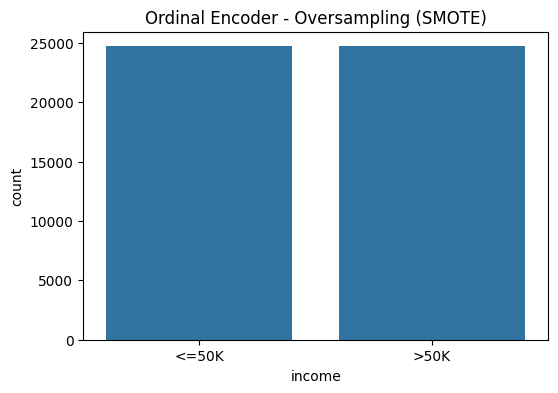

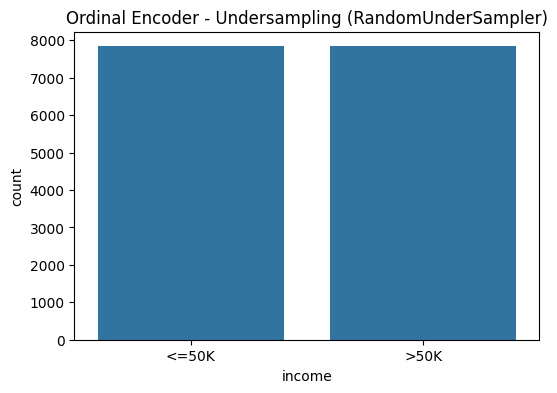

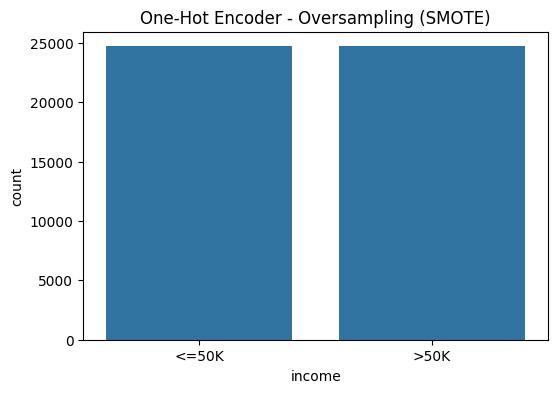

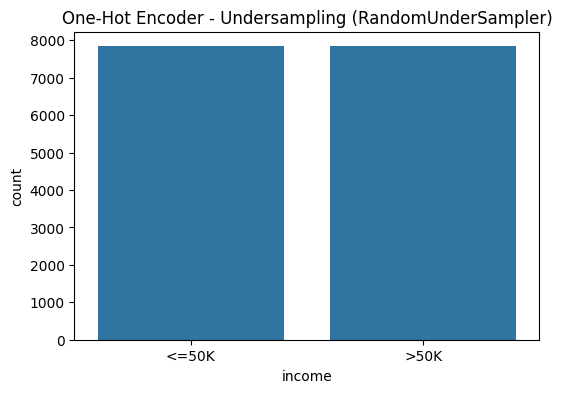

In [15]:
def plot_dist(df_in, title):
    plt.figure(figsize=(6,4))
    sns.countplot(x='income', data=df_in)
    plt.title(title)
    plt.show()

plot_dist(df_oe_oversampled, 'Ordinal Encoder - Oversampling (SMOTE)')
plot_dist(df_oe_undersampled, 'Ordinal Encoder - Undersampling (RandomUnderSampler)')
plot_dist(df_ohe_oversampled, 'One-Hot Encoder - Oversampling (SMOTE)')
plot_dist(df_ohe_undersampled, 'One-Hot Encoder - Undersampling (RandomUnderSampler)')

### Dokumentasi Hasil
1) Grafik 1: Ordinal Encoder - Oversampling (SMOTE)
Distribusi kelas target (income) setelah oversampling menunjukkan keseimbangan sempurna:
- <=50K: ~25.000 individu,
- (lebih dari) >50K: ~25.000 individu
2) Grafik 2: Ordinal Encoder - Undersampling (RandomUnderSampler)
Distribusi kelas target (income) setelah undersampling menunjukkan keseimbangan sempurna:
- <=50K: ~8.000 individu,
- (lebih dari) >50K: ~8.000 individu
3) Grafik 3: One-Hot Encoder - Oversampling (SMOTE)
Distribusi kelas target (income) setelah oversampling menunjukkan keseimbangan sempurna:
- <=50K: ~25.000 individu
- (lebih dari) >50K: ~25.000 individu

## Bagian 6 — Split Data & Evaluasi dengan Cross Validation (K-Fold = 5)

**Penjelasan:** Gunakan 5-Fold Cross Validation untuk mengevaluasi dua model: Decision Tree dan Logistic Regression. Lakukan evaluasi pada keempat dataset hasil sampling.

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Encode target labels to 0/1 for sklearn where necessary
le = LabelEncoder()
# Prepare dataset dictionary for evaluation
datasets = {
    'Ordinal Oversampling': (df_oe_oversampled.drop('income', axis=1).values, le.fit_transform(df_oe_oversampled['income'])),
    'Ordinal Undersampling': (df_oe_undersampled.drop('income', axis=1).values, le.fit_transform(df_oe_undersampled['income'])),
    'OneHot Oversampling': (df_ohe_oversampled.drop('income', axis=1).values, le.fit_transform(df_ohe_oversampled['income'])),
    'OneHot Undersampling': (df_ohe_undersampled.drop('income', axis=1).values, le.fit_transform(df_ohe_undersampled['income']))
}

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

k = 5
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Function to compute cross-validated metrics
def cv_metrics(model, X, y, cv):
    scoring = ['accuracy','precision','recall','f1']
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    return {metric: scores['test_' + metric].mean() for metric in scoring}

results = []
for ds_name, (X_ds, y_ds) in datasets.items():
    for model_name, model in models.items():
        met = cv_metrics(model, X_ds, y_ds, kfold)
        results.append({
            'dataset': ds_name,
            'model': model_name,
            **met
        })

results_df = pd.DataFrame(results).sort_values(by=['dataset','model']).reset_index(drop=True)
results_df

,dataset,model,accuracy,precision,recall,f1
0,OneHot Oversampling,Decision Tree,0.853430,0.849829,0.858571,0.854171
1,OneHot Oversampling,Logistic Regression,0.829136,0.811498,0.857438,0.833829
2,OneHot Undersampling,Decision Tree,0.771909,0.773283,0.769486,0.771321
3,OneHot Undersampling,Logistic Regression,0.821853,0.807084,0.846028,0.826043
4,Ordinal Oversampling,Decision Tree,0.724937,0.718446,0.739817,0.728963
5,Ordinal Oversampling,Logistic Regression,0.532978,0.532055,0.547170,0.539499
6,Ordinal Undersampling,Decision Tree,0.504528,0.504456,0.509885,0.507124
7,Ordinal Undersampling,Logistic Regression,0.539290,0.539023,0.542416,0.540703


### Dokumentasi Hasil Evaluasi Model (5-Fold Stratified CV)
- OneHot Oversampling (SMOTE):
> Decision Tree terbaik dengan accuracy 85.3%, F1 85.4%; Logistic Regression sedikit di bawah (F1 83.4%).
- OneHot Undersampling (RUS):
> Logistic Regression unggul (F1 82.6%), Decision Tree turun ke F1 77.1%.
- Ordinal Oversampling (SMOTE):
> Decision Tree cukup baik (F1 72.9%), tapi Logistic Regression gagal total (F1 53.9%).
- Ordinal Undersampling (RUS):
> Kedua model hampir acak — Decision Tree (F1 50.7%), Logistic Regression (F1 54.1%).
- Kesimpulan:
> One-Hot + SMOTE + Decision Tree adalah kombinasi paling optimal (F1 tertinggi: 85.4%).
Ordinal Encoding tidak cocok untuk resampling, terutama dengan model linier.

### Evaluasi Tambahan — Classification Report pada salah satu kombinasi terbaik

**Penjelasan:** Setelah melihat hasil cross-validation, kita dapat memilih kombinasi terbaik (misal berdasarkan accuracy) dan menampilkan classification report menggunakan Stratified train-test split untuk melihat precision/recall/f1 per kelas.

In [17]:
# Pilih kombinasi dengan akurasi tertinggi
best_row = results_df.loc[results_df['accuracy'].idxmax()]
best_row

,0
dataset,OneHot Oversampling
model,Decision Tree
accuracy,0.85343
precision,0.849829
recall,0.858571
f1,0.854171


### Kesimpulan Hasil:
One-Hot Encoding + SMOTE + Decision Tree adalah pipeline optimal dengan performa terbaik secara keseluruhan (F1 ≈ 85.4%), siap digunakan untuk prediksi akhir.

In [18]:
# Menampilkan classification report untuk best combination using a stratified split
best_ds = best_row['dataset']
best_model_name = best_row['model']

X_best, y_best = datasets[best_ds]
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_best, y_best, test_size=0.2, stratify=y_best, random_state=42)

model_inst = models[best_model_name]
model_inst.fit(X_tr, y_tr)
y_pred = model_inst.predict(X_te)

print('Classification Report for', best_model_name, 'on', best_ds)
print(classification_report(y_te, y_pred, target_names=le.classes_))

Classification Report for Decision Tree on OneHot Oversampling
              precision    recall  f1-score   support

       <=50K       0.86      0.85      0.85      4940
        >50K       0.85      0.86      0.85      4940

    accuracy                           0.85      9880
   macro avg       0.85      0.85      0.85      9880
weighted avg       0.85      0.85      0.85      9880



## Bagian 7 — Kesimpulan Analisis
- Ringkasan:
>- SMOTE (oversampling) terbukti sangat efektif meningkatkan performa model pada dataset highly imbalanced, terutama ketika dipadukan dengan One-Hot Encoding dan Decision Tree.
>- Undersampling (RUS) cepat dan hemat memori, namun berisiko kehilangan informasi penting dari kelas mayoritas, terlihat dari penurunan performa signifikan (F1 turun dari 0.85 → 0.77).
>- Ordinal Encoding gagal total pada resampling (F1 < 0.54), menunjukkan ketidakcocokan dengan model linier dan data sintetis SMOTE.
- Kombinasi Terbaik (dari 5-Fold CV + Test Set):
> One-Hot Encoding + SMOTE + Decision Tree
>- Accuracy: 85.3% (CV), 85.0% (test)
>- F1-Score: 0.854 (CV), 0.85 (test)
>- Seimbang pada kedua kelas (<=50K & >50K) → tidak ada bias prediksi.
- Alasan Pemilihan:
>- One-Hot menghindari asumsi urutan kategori (vs Ordinal).
>- SMOTE mempertahankan informasi asli + menambah sampel sintetis yang realistis.
>- Decision Tree tahan terhadap data berdimensi tinggi & non-linear.